# Classification de Drapeaux

## Installation des Bibliothèques

In [65]:
# pip install -r requierments.txt

  Using cached torchviz-0.0.2.tar.gz (4.9 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   -------- ------------------------------- 10.2/47.1 kB ? eta -:--:--
   ---------------------------------- ----- 41.0/47.1 kB 495.5 kB/s eta 0:00:01
   ---------------------------------------- 47.1/47.1 kB 472.9 kB/s eta 0:00:00
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4139 sha256=28de51a55055916c0842baa4dbb67d004386c3a580612a1390b39a74f3fd77a5
  Stored in directory: c:\users\paulz\appdata\local\packages\pyt

## Importations des bibliothèques

In [1]:
# Importation des packages
import os
import pickle
from PIL import Image
import cv2
import numpy as np

# Imporattion des packages sklearn pour knn et svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.svm import SVC

# panda
import pandas as pd

# Pour les graphique
import matplotlib.pyplot as plt

# PyTorch pour cnn et augmentation d'images
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import v2
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

## Augmentation des données

### Ajout de bruit gaussien

La fonction suivante ajoute aléatoirement des points de couleur sur l'image

In [5]:
def add_gaussian_noise(img, mean = 0, std = 25):
    """ Ajout de bruit gaussien à une image"""

    # Array de l'image
    img = np.array(img)

    # Génération de bruit gaussien avec la moyenne et l'écart-type
    noise = np.random.normal(mean, std, img.shape).astype(np.uint8)

    # Ajout du bruit à l'image et reconversion en image PIL
    noisy_img = cv2.add(img, noise)
    noisy_img = Image.fromarray(noisy_img)

    return noisy_img

### Ajouts des modifications

La fonction génère de nouvelles images suivants les modofications et les sauvegarde.

In [6]:
def img_data_augmentation(img_file, folder_path):

    # Importation de de l'image
    img = Image.open('flags/%s.png'%img_file).convert('RGB')
    img.thumbnail((128,128))

    # Définition des transformation
    bright_transformer = v2.ColorJitter(brightness=1, contrast=1, saturation=0.4)
    rotation_transformer = v2.RandomRotation(degrees=(-20,20))
    blur_transformer = v2.GaussianBlur(kernel_size=15, sigma=(0.1, 5))
    perspective_transformer = v2.RandomPerspective(distortion_scale=0.5, p=1)
    wave_transformer = v2.ElasticTransform(alpha=125)
    
    # Création de 10 version altérées des images
    # Pour chaque modification et paires de modifications
    for i in range(1,11):

        std = round(10**(i/5))
        noise=add_gaussian_noise(img,0,std)
        noise.save(f'{folder_path}/{img_file}_noise_{i}.png')
        noise_bright = bright_transformer(noise)
        noise_bright.save(f'{folder_path}/{img_file}_noise_bright_{i}.png')
        noise_rota = rotation_transformer(noise)
        noise_rota.save(f'{folder_path}/{img_file}_noise_rota_{i}.png')
        noise_blur = blur_transformer(noise)
        noise_blur.save(f'{folder_path}/{img_file}_noise_blur_{i}.png')
        noise_per = perspective_transformer(noise)
        noise_per.save(f'{folder_path}/{img_file}_noise_per_{i}.png')
        noise_wave = wave_transformer(noise)
        noise_wave.save(f'{folder_path}/{img_file}_noise_wave_{i}.png')

        bright = bright_transformer(img)
        bright.save(f'{folder_path}/{img_file}_bright_{i}.png')
        bright_rota = rotation_transformer(bright)
        bright_rota.save(f'{folder_path}/{img_file}_bright_rota_{i}.png')
        bright_blur = blur_transformer(bright)
        bright_blur.save(f'{folder_path}/{img_file}_bright_blur_{i}.png')
        bright_per = perspective_transformer(bright)
        bright_per.save(f'{folder_path}/{img_file}_bright_per_{i}.png')
        bright_wave = wave_transformer(bright)
        bright_wave.save(f'{folder_path}/{img_file}_bright_wave_{i}.png')

        rota = rotation_transformer(img)
        rota.save(f'{folder_path}/{img_file}_rota_{i}.png')
        rota_blur = blur_transformer(rota)
        rota_blur.save(f'{folder_path}/{img_file}_rota_blur_{i}.png')
        rota_per = perspective_transformer(rota)
        rota_per.save(f'{folder_path}/{img_file}_rota_per_{i}.png')
        rota_wave = wave_transformer(rota)
        rota_wave.save(f'{folder_path}/{img_file}_rota_wave_{i}.png')

        blur = blur_transformer(img)
        blur.save(f'{folder_path}/{img_file}_blur_{i}.png')
        blur_per = perspective_transformer(blur)
        blur_per.save(f'{folder_path}/{img_file}_blur_per_{i}.png')
        blur_wave = wave_transformer(blur)
        blur_wave.save(f'{folder_path}/{img_file}_blur_wave_{i}.png')

        per = perspective_transformer(img)
        per.save(f'{folder_path}/{img_file}_per_{i}.png')
        per_wave = wave_transformer(per)
        per_wave.save(f'{folder_path}/{img_file}_per_wave_{i}.png')

        wave = wave_transformer(img)
        wave.save(f'{folder_path}/{img_file}_wave_{i}.png')

## Création des données

Sélectionne 10 drapeaux aléatoirements et appelle la fonction d'augmentation d'images.

In [2]:
# Définition des chemins
FLAG_LIST_DIR = 'flag_list.txt'
DATASET_DIR = 'inputs/all_flags_input_data'

# Liste de tous les drapeaux
with open(FLAG_LIST_DIR, 'r') as f:
    flags = [line[:-1] for line in f]

# Choix de 10 drapeaux aléatoires
selected_flags = np.random.choice(flags,10)

# Crée le dossier d'inputs s'il n'existe pas
if not os.path.exists(DATASET_DIR):
    os.makedirs(DATASET_DIR)

    for flag in selected_flags:

        # Crée le dessier du drapeaux
        flag_dir = '{0}/{1}'.format(DATASET_DIR,flag)

        if os.path.exists(flag_dir) == False:
            os.makedirs(flag_dir)

            # Agmentations des images
            img_data_augmentation(flag, flag_dir)

else:
    print('Input Folder already exists.')

Input Folder already exists.


Ajout des modifications pour le jeu de données kaggle

In [7]:
DATASET_DIR = 'inputs/kaggle_flag_test'

# Modificateurs
bright_transformer = v2.ColorJitter(brightness=1, contrast=1, saturation=0.4)
rotation_transformer = v2.RandomRotation(degrees=(-20,20))
blur_transformer = v2.GaussianBlur(kernel_size=15, sigma=(0.1, 5))
perspective_transformer = v2.RandomPerspective(distortion_scale=0.5, p=1)
wave_transformer = v2.ElasticTransform(alpha=125)

# Dictionnaire des modificateurs
modif_dict = {'blur' : blur_transformer,
              'bright' : bright_transformer,
              'noise' : add_gaussian_noise,
              'perspective' : perspective_transformer,
              'rotation': rotation_transformer,
              'wave' : wave_transformer}

# Répertoires de chaques drapeaux
for flag_dir in os.listdir(DATASET_DIR):
    folder_path = f'{DATASET_DIR}/{flag_dir}'
    
    # Vérifie que le dossier n'a pas déja de modifications
    if len(os.listdir(folder_path)) < 150:
        for img in os.listdir(folder_path):

            # Importation de l'image
            img_path = f'{DATASET_DIR}/{flag_dir}/{img}'
            img = Image.open(img_path).convert('RGB')
            img.thumbnail((128,128))
            
            # Redéfiniton du chemin sans l'extention de fichier
            img_path = img_path[:-4]

            # Applique 5x chaques modifications
            for name, modif in modif_dict.items():

                for i in range(5):
                    aug_img = modif(img)
                    aug_img.save(f'{img_path}_{name}_{i}.png')

print('Done!')

Done!


Création de version réduites du jeu de données augmentées kaggle, avec 500 individus par drapeaux et 200 pour le jeu de test du cnn.

In [7]:
# Définition des répertoires
SMALL_DATASET_DIR = 'inputs/kaggle_small'
SMALL_TEST_DIR = 'inputs/kaggle_small_test'

# Crée le répertoires
if not os.path.exists(SMALL_DATASET_DIR):
    os.makedirs(SMALL_DATASET_DIR)

    for flag_dir in os.listdir(DATASET_DIR):
        #Répertoires pour chaque drapeaux
        os.makedirs(f'{SMALL_DATASET_DIR}/{flag_dir}')
        os.makedirs(f'{SMALL_TEST_DIR}/{flag_dir}')
        
        folder_path = f'{DATASET_DIR}/{flag_dir}'
        imgs = os.listdir(folder_path)

        # Sélection aléatoire de 700 images par drapeaux
        selected_imgs = list(np.random.choice(imgs, 700))
        # Sélection aléatoire de 200 des 700 images pour le jeu de test
        test_imgs = list(np.random.choice(selected_imgs, 200))
        
        # Ajouts des images sélectionnées dans les répertoires
        for img in test_imgs:
            img_path = f'{folder_path}/{img}'
            flag_img = Image.open(img_path)
            flag_img.save(f'{SMALL_TEST_DIR}/{flag_dir}/{img}')

            if img in selected_imgs:
                selected_imgs.remove(img)

        for img in selected_imgs:
           
            img_path = f'{folder_path}/{img}'
            flag_img = Image.open(img_path)
            flag_img.save(f'{SMALL_DATASET_DIR}/{flag_dir}/{img}')

In [8]:
DATASET_DIR = SMALL_DATASET_DIR

## Pré-traitement des données

In [3]:
def load_images(input_dir):
    """ Charge les images et leur label"""

    # Liste des images et labels 
    images = []
    labels = []

    for folder in os.listdir(input_dir):
        label_folder = os.path.join(input_dir, folder)
        
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):

                # Importation de l'image
                img_path = os.path.join(label_folder, filename)
                img = cv2.imread(img_path)

                if img is not None:
                    images.append(img)
                    # Ajout du nom de dossier comme label
                    labels.append(folder)

    return images, labels

In [4]:
def preprocess_images(images, size=(32, 32)):
    """ Pré-traitement des images pour les kNN et SVM"""

    # liste des images prétraitées
    preprocessed_images = []

    for img in images:
        # Redimmentionne l'image
        resized_img = cv2.resize(img, size)
        # Réduit l'image à 1 dimention
        flattened_img = resized_img.flatten()
        # Ajoute l'image à la liste
        preprocessed_images.append(flattened_img)
    
    return np.array(preprocessed_images)

In [36]:
# Charge les image et leur label
images, labels = load_images(DATASET_DIR)
images = preprocess_images(images, (32 ,32))
labels = np.array(labels)

# Encode les labels en valeurs numérique
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [37]:
# Suppression des doublons dans le jeu de données
images = pd.DataFrame(images)
dupli_label = images[images.duplicated()].index
dupli_label = dupli_label.to_numpy()

encoded_labels = np.delete(encoded_labels, dupli_label, None)

images = images.drop_duplicates()

print(len(encoded_labels), len(images))

40519 40519


In [38]:
# Séparation en jeu d'entraînment et de test
X_train, X_test, y_train, y_test = train_test_split(images,
                                                    encoded_labels,
                                                    test_size=0.3,
                                                    random_state=1)

# Standardisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f'train: {len(X_train)} individus')
print(f'test: {len(X_test)} individus')

train: 28363 individus
test: 12156 individus


## k Nearest Neighbour

In [12]:
# Paramètres pour le nombre de voisins
k_par = list(range(1, 21))
# Dictionnaire des paramètres
param_dict = {'n_neighbors': k_par,
              'weights': ['uniform', 'distance']}
# nombre de cross-validation
n_cv = 4

# Recherche sur grille avec CV
knn_classifier = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn_classifier,
                                param_dict,
                                verbose=3,
                                cv=n_cv)
grid_search_knn.fit(X_train, y_train)

Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV 1/4] END ....n_neighbors=1, weights=uniform;, score=0.888 total time=   0.2s
[CV 2/4] END ....n_neighbors=1, weights=uniform;, score=0.870 total time=   0.1s
[CV 3/4] END ....n_neighbors=1, weights=uniform;, score=0.878 total time=   0.1s
[CV 4/4] END ....n_neighbors=1, weights=uniform;, score=0.871 total time=   0.1s
[CV 1/4] END ...n_neighbors=1, weights=distance;, score=0.888 total time=   0.1s
[CV 2/4] END ...n_neighbors=1, weights=distance;, score=0.870 total time=   0.1s
[CV 3/4] END ...n_neighbors=1, weights=distance;, score=0.878 total time=   0.1s
[CV 4/4] END ...n_neighbors=1, weights=distance;, score=0.871 total time=   0.1s
[CV 1/4] END ....n_neighbors=2, weights=uniform;, score=0.859 total time=   0.1s
[CV 2/4] END ....n_neighbors=2, weights=uniform;, score=0.853 total time=   0.1s
[CV 3/4] END ....n_neighbors=2, weights=uniform;, score=0.843 total time=   0.1s
[CV 4/4] END ....n_neighbors=2, weights=uniform

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'weights': ['uniform', 'distance']},
             verbose=3)

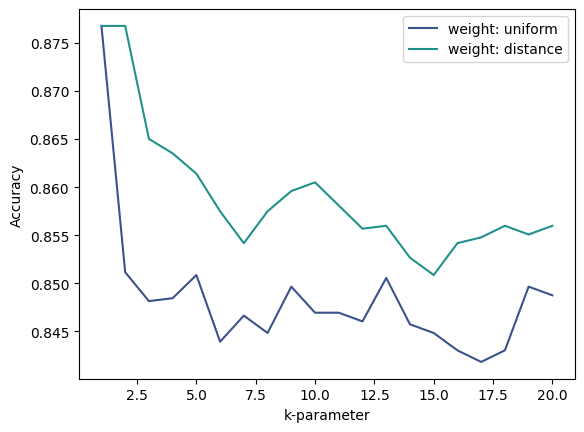

In [13]:
# Exactitude pour chaque poids
accuracy_uni = grid_search_knn.cv_results_['mean_test_score'][0::2]
accuracy_dist = grid_search_knn.cv_results_['mean_test_score'][1::2]

# Graphique k - accuracy
plt.plot(k_par, accuracy_uni, c='#3b528b', label = 'weight: uniform')
plt.plot(k_par, accuracy_dist, c='#21918c', label = 'weight: distance')
plt.xlabel('k-parameter')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
# Meilleurs paramètres de la cross validation
accuracy_knn_test = grid_search_knn.best_estimator_.score(X_test, y_test)
best_k = grid_search_knn.best_params_['n_neighbors']
best_weights = grid_search_knn.best_params_['weights']

print(f'k-NN: meilleure paramètre k = {best_k}')
print(f'k-NN: meilleure poids: {best_weights}')
print(f'k-NN: meilleure exactitude d\'entrainement = {grid_search_knn.best_score_: .2%}')
print(f'k-NN: meilleure exactitude de test = {accuracy_knn_test: .2%}')

k-NN: meilleure paramètre k = 1
k-NN: meilleure poids: uniform
k-NN: meilleure exactitude d'entrainement =  87.68%
k-NN: meilleure exactitude de test =  88.40%


In [39]:
# kNN avec meilleurs paramètres
best_knn = KNeighborsClassifier(n_neighbors=best_k, weights=best_weights)
best_knn.fit(X_train, y_train)

# Prédiction
y_knn_train = (best_knn.predict(X_train))
y_knn_test = (best_knn.predict(X_test))

#Calcul et affichage de l'exactitude
accuracy_knn_train = accuracy_score(y_train, y_knn_train)
accuracy_knn_test = accuracy_score(y_test, y_knn_test)
print(f'Exactitude: {accuracy_knn_train:.2%} (train) & {accuracy_knn_test:.2%}\
 (test)')

#Calcul et affichage de la precision
precision_knn_train = precision_score(y_train, y_knn_train,
                                      average='weighted')
precision_knn_test = precision_score(y_test, y_knn_test, 
                                     average='weighted')
print(f'Précision: {precision_knn_train:.2%} (train) & {precision_knn_test:.2%}\
 (test)')

#Calcul et affichage du rappel
recall_knn_train = recall_score(y_train, y_knn_train,
                                average='weighted')
recall_knn_test = recall_score(y_test, y_knn_test,
                               average='weighted')
print(f'Rappel: {recall_knn_train:.2%} (train) & {recall_knn_test:.2%} (test)')

#Calcul et affichage des scores f1
f1_knn_train = f1_score(y_train, y_knn_train,
                        average='weighted')
f1_knn_test = f1_score(y_test, y_knn_test, average='weighted')
print(f'Score F1: {f1_knn_train:.2%} (train) & {f1_knn_test:.2%} (test)')

Exactitude: 100.00% (train) & 82.75% (test)
Précision: 100.00% (train) & 84.33% (test)
Rappel: 100.00% (train) & 82.75% (test)
Score F1: 100.00% (train) & 83.14% (test)


In [16]:
# Sauvegarde du modèle
MODELS_DIR = 'models'
os.makedirs(MODELS_DIR, exist_ok=True)

knn_pickle = open(f'{MODELS_DIR}/knn_model_kd', 'wb')
pickle.dump(best_knn, knn_pickle)

## Support Vector Machine

In [17]:
#paramètres du SVC
C = [0.1, 1, 10]
gamma_par = [0.0001, 0.001, 0.01 ,0.1 ,1]#[round(i,4) for i in np.linspace(0.001, 1, 5)]
kernels = ['poly', 'rbf', 'sigmoid']

# Dictionnaire des paramètres
param_dict = {'C': C,
              'gamma': gamma_par, 
              'kernel': kernels}

#nombre de plis
n_cv = 4

#Cross-validation
svm_classifier = SVC()
grid_search_svm = GridSearchCV(svm_classifier,
                               param_dict,
                               cv=n_cv,
                               verbose = 3
                               )
grid_search_svm.fit(X_train, y_train)

Fitting 4 folds for each of 45 candidates, totalling 180 fits
[CV 1/4] END ..C=0.1, gamma=0.0001, kernel=poly;, score=0.105 total time=  20.3s
[CV 2/4] END ..C=0.1, gamma=0.0001, kernel=poly;, score=0.108 total time=  19.3s
[CV 3/4] END ..C=0.1, gamma=0.0001, kernel=poly;, score=0.106 total time=  20.0s
[CV 4/4] END ..C=0.1, gamma=0.0001, kernel=poly;, score=0.109 total time=  19.4s
[CV 1/4] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.834 total time=  14.6s
[CV 2/4] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.824 total time=  11.3s
[CV 3/4] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.843 total time=  11.0s
[CV 4/4] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.841 total time=  11.0s
[CV 1/4] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.810 total time=   9.8s
[CV 2/4] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.790 total time=   9.8s
[CV 3/4] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.801 total time=   9.8s
[CV 4/4] END C=0.1, gamma=0.0001, kernel=sig

GridSearchCV(cv=4, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             verbose=3)

[]

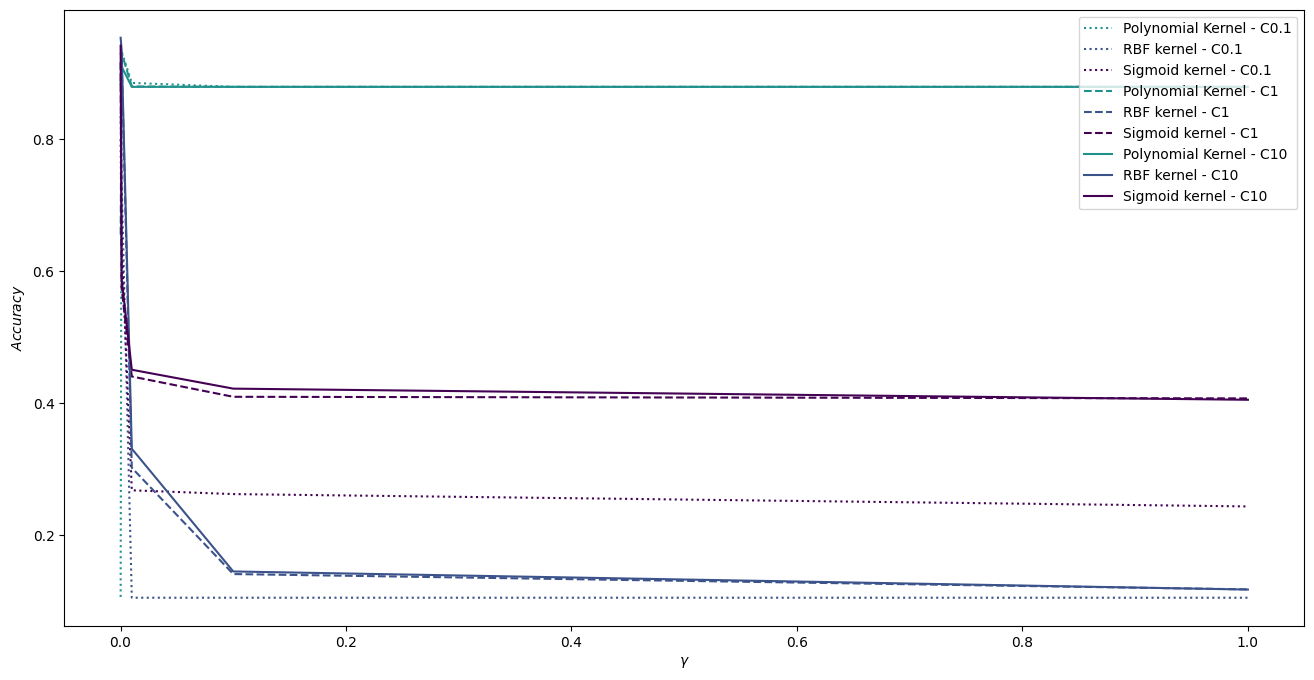

In [18]:
#exactitude moyenne par cv (renvoie une liste des scores avec les trois kernels)
accuracy = grid_search_svm.cv_results_['mean_test_score']

#récupération du score pour chaque kernel C=0.1
poly_accuracy_c1 = accuracy[0::3][0:5]
rbf_accuracy_c1 = accuracy[1::3][0:5]
sig_accuracy_c1 = accuracy[2::3][0:5]

#récupération du score pour chaque kernel C=1
poly_accuracy_c2 = accuracy[0::3][5:10]
rbf_accuracy_c2 = accuracy[1::3][5:10]
sig_accuracy_c2 = accuracy[2::3][5:10]

#récupération du score pour chaque kernel C=10
poly_accuracy_c3 = accuracy[0::3][10:]
rbf_accuracy_c3 = accuracy[1::3][10:]
sig_accuracy_c3 = accuracy[2::3][10:]

# Graphique pour de l'exactitude en fonction de gamma pour chaque kernel et C
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(gamma_par, poly_accuracy_c1, c='#21918c', linestyle='dotted', label=f'Polynomial Kernel - C{C[0]}')
ax.plot(gamma_par, rbf_accuracy_c1, c='#3b528b', linestyle='dotted', label=f'RBF kernel - C{C[0]}')
ax.plot(gamma_par, sig_accuracy_c1, c='#440154', linestyle='dotted',label=f'Sigmoid kernel - C{C[0]}')

ax.plot(gamma_par, poly_accuracy_c2, c='#21918c', linestyle='dashed', label=f'Polynomial Kernel - C{C[1]}')
ax.plot(gamma_par, rbf_accuracy_c2, c='#3b528b', linestyle='dashed', label=f'RBF kernel - C{C[1]}')
ax.plot(gamma_par, sig_accuracy_c2, c='#440154', linestyle='dashed', label=f'Sigmoid kernel - C{C[1]}')

ax.plot(gamma_par, poly_accuracy_c3, c='#21918c', label=f'Polynomial Kernel - C{C[2]}')
ax.plot(gamma_par, rbf_accuracy_c3, c='#3b528b', label=f'RBF kernel - C{C[2]}')
ax.plot(gamma_par, sig_accuracy_c3, c='#440154', label=f'Sigmoid kernel - C{C[2]}')

ax.set_xlabel('$\gamma$')
ax.set_ylabel('$Accuracy$')
ax.legend(loc='upper right')
plt.plot()

In [19]:
# Meilleurs paramètres du SVM lors de la CV
best_kernel = grid_search_svm.best_params_['kernel']
best_gamma = grid_search_svm.best_params_['gamma']
best_C = grid_search_svm.best_params_['C']
accuracy_svm_test = grid_search_svm.best_estimator_.score(X_test, y_test)

# Meilleurs paramètres et exactitude de la cv
print(f'SVM: Meilleures paramètres C: {best_C}')
print(f'SVM: Meilleures kernel: {best_kernel}')
print(f'SVM: Meilleures paramètres gamma: {best_gamma}')
print(f'SVM: Meilleure exactitude d\'entraînement{grid_search_svm.best_score_: .2%} ')
print(f'SVM: Meilleure exactitude de test{accuracy_svm_test: .2%} ')

SVM: Meilleures paramètres C: 10
SVM: Meilleures kernel: rbf
SVM: Meilleures paramètres gamma: 0.0001
SVM: Meilleure exactitude d'entraînement 95.39% 
SVM: Meilleure exactitude de test 94.66% 


In [40]:
# SVM avec les meilleurs paramètres
best_svm = SVC(C=10, kernel='rbf', gamma=0.0001)#SVC(C=best_C,kernel=best_kernel, gamma=best_gamma, probability=True)
best_svm.fit(X_train, y_train)

# Prédiction
outputs_svm_train = (best_svm.predict(X_train))
outputs_svm_test = (best_svm.predict(X_test))

# Calcul et affichage de l'exactitude
accuracy_svm_train = accuracy_score(y_train, outputs_svm_train)
accuracy_svm_test = accuracy_score(y_test, outputs_svm_test)
print(f'Exactitude: {accuracy_svm_train:.2%} (train) & {accuracy_svm_test:.2%}\
 (test)')

# Calcul et affichage de la precision
precision_svm_train = precision_score(y_train, outputs_svm_train,
                                      average='weighted')
precision_svm_test = precision_score(y_test, outputs_svm_test, 
                                     average='weighted')
print(f'Précision: {precision_svm_train:.2%} (train) & {precision_svm_test:.2%}\
 (test)')

# Calcul et affichage du rappel
recall_svm_train = recall_score(y_train, outputs_svm_train,
                                average='weighted')
recall_svm_test = recall_score(y_test, outputs_svm_test,
                               average='weighted')
print(f'Rappel: {recall_svm_train:.2%} (train) & {recall_svm_test:.2%} (test)')

# Calcul et affichage des scores f1
f1_svm_train = f1_score(y_train, outputs_svm_train,
                        average='weighted')
f1_svm_test = f1_score(y_test, outputs_svm_test, average='weighted')
print(f'Score F1: {f1_svm_train:.2%} (train) & {f1_svm_test:.2%} (test)')

Exactitude: 93.99% (train) & 89.37% (test)
Précision: 97.49% (train) & 93.73% (test)
Rappel: 93.99% (train) & 89.37% (test)
Score F1: 95.35% (train) & 91.00% (test)


In [21]:
# Sauvegarde du modèle SVM
svm_pickle = open(f'{MODELS_DIR}/svm_model_kd', 'wb')
pickle.dump(best_svm, svm_pickle)

## Convolutional Neural Network

In [3]:
# Check si une carte graphique compatible est diponible
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
# Pré-traitement pour cnn
input_dataset = datasets.ImageFolder(root=DATASET_DIR,
                                     transform=transforms.Compose([
                                        transforms.Resize((32, 32)),
                                        transforms.ToTensor()]))

# Calcul de la moyenne et écart-type des images pour la standardisation
image_mean = torch.stack([t.mean(1).mean(1) for t, c in input_dataset]).mean(0)
image_std = torch.stack([t.std(1).std(1) for t, c in input_dataset]).mean(0)
print(f'mean: {image_mean}, std: {image_std}')

# Pré-traitement avec standardisation
input_transform = transforms.Compose([transforms.Resize((32, 32)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=image_mean, std=image_std)])

input_dataset = datasets.ImageFolder(root=DATASET_DIR,
                                     transform = input_transform)

# Séparation en jeu d'entrainement et validation
seed = torch.Generator().manual_seed(1)
train_dataset, valid_dataset = random_split(input_dataset, [0.8, 0.2], generator=seed)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

num_classes = len(input_dataset.classes)
print(num_classes)

mean: tensor([0.4968, 0.4211, 0.3947]), std: tensor([0.0780, 0.0667, 0.0608])
195


In [24]:
# Création du modèle resnet18
model = models.resnet18(weights='DEFAULT')
num_features = model.fc.in_features

# Dernière couche entièrement cannecté avec le bon nombre de classes
model.fc = nn.Linear(num_features, num_classes)

# fonction de perte et optimisateur
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
# Dossier des chqckpoints
CHECKPOINTS_DIR = 'checkpoints'
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

In [26]:
num_epochs = 20

# Listes pour enregistrer les pertes moyennes
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(1,num_epochs+1):

  # ---- Entrainement

    model.train()
    train_loss = 0
    train_correct = 0
    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logit_outputs = model(inputs)
        loss = criterion(logit_outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (logit_outputs.argmax(1) == labels).sum().item()

    # ---- Validation

    model.eval()
    valid_loss = 0
    valid_correct = 0

    for inputs, labels in valid_loader:


        inputs = inputs.to(device)
        labels = labels.to(device)


        logit_outputs = model(inputs)
        loss = criterion(logit_outputs, labels)


        valid_loss += loss.item()
        valid_correct += (logit_outputs.argmax(1) == labels).sum().item()

    # Affichage 

    # Calcul de la perte moyenne et exactitude moyenne
    train_mean_loss = train_loss / len(train_loader.dataset)
    valid_mean_loss = valid_loss / len(valid_loader.dataset)
    train_mean_accuracy = train_correct / len(train_loader.dataset)
    valid_mean_accuracy = valid_correct / len(valid_loader.dataset)


    # Ajouter les pertes moyennes aux listes
    train_losses.append(train_mean_loss)
    valid_losses.append(valid_mean_loss)
    train_accuracies.append(train_mean_accuracy)
    valid_accuracies.append(valid_mean_accuracy)

    # Print
    print(f'Epoch {epoch}/{num_epochs} : '
              f'train loss = {train_mean_loss:.4f}, '
              f'train accuracy = {train_mean_accuracy:.3%}, '
              f'valid loss = {valid_mean_loss:.4f}, '
              f'valid accuracy = {valid_mean_accuracy:.3%}.')

    # Engistrement
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_tat_dict': optimizer.state_dict(),
                'train_loss': train_mean_loss,
                'valid_loss': valid_mean_loss,
                'train_accuracy': train_mean_accuracy,
                'valid_accuracy': valid_mean_accuracy}, 
               f'{CHECKPOINTS_DIR}/model_{epoch}.pt')
                                       

Epoch 1/20 : train loss = 0.0184, train accuracy = 81.240%, valid loss = 0.0041, valid accuracy = 96.109%.
Epoch 2/20 : train loss = 0.0050, train accuracy = 95.481%, valid loss = 0.0036, valid accuracy = 97.161%.
Epoch 3/20 : train loss = 0.0032, train accuracy = 97.005%, valid loss = 0.0026, valid accuracy = 97.581%.
Epoch 4/20 : train loss = 0.0023, train accuracy = 97.714%, valid loss = 0.0025, valid accuracy = 97.476%.
Epoch 5/20 : train loss = 0.0025, train accuracy = 97.819%, valid loss = 0.0023, valid accuracy = 97.581%.
Epoch 6/20 : train loss = 0.0020, train accuracy = 98.056%, valid loss = 0.0017, valid accuracy = 98.002%.
Epoch 7/20 : train loss = 0.0013, train accuracy = 98.581%, valid loss = 0.0021, valid accuracy = 98.107%.
Epoch 8/20 : train loss = 0.0013, train accuracy = 98.870%, valid loss = 0.0022, valid accuracy = 98.002%.
Epoch 9/20 : train loss = 0.0014, train accuracy = 98.739%, valid loss = 0.0022, valid accuracy = 97.897%.
Epoch 10/20 : train loss = 0.0013, tr

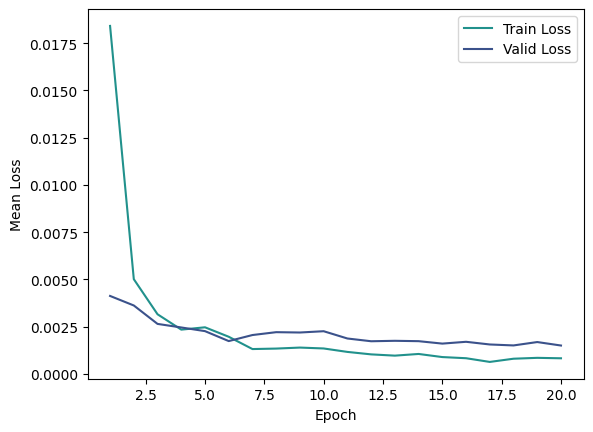

In [27]:
# Graph de la perte des moyennes
plt.figure()
plt.plot(range(1, num_epochs + 1),  train_losses, c='#21918c', label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, c='#3b528b', label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Loss')
# plt.title('Perte moyenne par Epoch')
plt.legend()
plt.show()

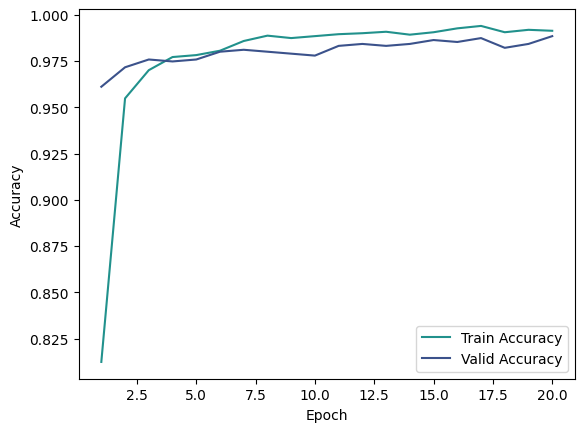

In [28]:
# Graph de l'exactitude/epoch
plt.figure()
plt.plot(range(1, num_epochs + 1),  train_accuracies, c='#21918c', label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, c='#3b528b', label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.title('Accuracy par Epoch')
plt.legend()
plt.show()

In [29]:
# Définition de la meilleur epoch
best_epoch = valid_accuracies.index(max(valid_accuracies)) + 1
print(f'Meilleur Epoch : {best_epoch}')

Meilleur Epoch : 20


In [30]:
# Sauvegarde du meilleur modèle
best_checkpoint = torch.load(f'{CHECKPOINTS_DIR}/model_{best_epoch}.pt')
torch.save(best_checkpoint, f'{MODELS_DIR}/resnet_model_kd.pt')

# Définition du modèle avec les meilleurs params
best_cnn = models.resnet18(weights='DEFAULT')
best_cnn.fc = nn.Linear(num_features, num_classes)
best_cnn.load_state_dict(best_checkpoint['model_state_dict'])
best_valid_accuracy = best_checkpoint['valid_accuracy']
print(f'CNN : Meilleur exactitude de validation: {best_valid_accuracy:.2%}')

CNN : Meilleur exactitude de validation: 98.84%


In [14]:
# Chargement et pré-traitement du jeu de tests
TEST_DIR = 'inputs/kaggle_small_test'

test_dataset = datasets.ImageFolder(root=TEST_DIR,
                                     transform = input_transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [32]:
# Modèle en mode d'évalutaion
best_cnn.eval()
best_cnn.to(device)

test_correct = 0
all_preds = []
all_labels = []

# Prédictions du jeu de test
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        logit_outputs = best_cnn(inputs)
        preds = logit_outputs.argmax(1)
        
        test_correct += (preds == labels).sum().item()
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculer l'accuracy, la précision, le rappel et le score F1
test_accuracy = test_correct / len(test_loader.dataset)
test_precision = precision_score(all_labels, all_preds, average='weighted')
test_recall = recall_score(all_labels, all_preds, average='weighted')
test_f1 = f1_score(all_labels, all_preds, average='weighted')

# Affichage des résultats
print(f'Exactitude:  {test_accuracy:.2%}')
print(f'Precision: {test_precision:.2%}')
print(f'Rappel: {test_recall:.2%}')
print(f'Score F1: {test_f1:.2%}')

Exactitude:  98.98%
Precision: 99.00%
Rappel: 98.98%
Score F1: 98.98%


## CNN - Personnel

In [5]:
class MyCNN(nn.Module):
    """
    Définition du réseau de neuronnes
    """

    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3) # Convolution avec kernel 3x3 et 16 sorties
        self.pool = nn.MaxPool2d(2, 2)  # MaxPooling 2x2
        self.conv2 = nn.Conv2d(16, 32, 4) # Convolution avec kernel 4x4 et 32 sorties

        # Couches entièrement connectées
        # W'=((W-F+2P)/S) + 1 (Width, Filter size, Padding, Stride)
        self.fc1 = nn.Linear(32*6*6, 512)  # sorties x W' x W'
        self.fc2 = nn.Linear(512, 256)
        # Dernière couche avec bon nombre de classes
        self.fc3 = nn.Linear(256, 195) 
        
    def forward(self, x):

        # MaxPooling sur la conv1 avec activation ReLu
        x = self.pool(F.relu(self.conv1(x)))
        # MaxPooling sur la conv2 avec activation ReLu
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


In [6]:
# Création du modèle
my_model = MyCNN()

# fonction de perte et optimisateur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_model.parameters(), lr=0.001)

my_model.to(device)

MyCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=195, bias=True)
)

In [7]:
# Répertoires des checkpoints
MYCNN_CHECKPOINTS_DIR = 'MyCNN-checkpoints'
os.makedirs(MYCNN_CHECKPOINTS_DIR, exist_ok=True)

In [8]:
num_epochs = 20

# Listes pour enregistrer les pertes moyennes
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(1,num_epochs+1):

  # ---- Entrainement

    my_model.train()
    train_loss = 0
    train_correct = 0
    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logit_outputs = my_model(inputs)
        loss = criterion(logit_outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (logit_outputs.argmax(1) == labels).sum().item()

    # ---- Validation

    my_model.eval()
    valid_loss = 0
    valid_correct = 0

    for inputs, labels in valid_loader:


        inputs = inputs.to(device)
        labels = labels.to(device)


        logit_outputs = my_model(inputs)
        loss = criterion(logit_outputs, labels)


        valid_loss += loss.item()
        valid_correct += (logit_outputs.argmax(1) == labels).sum().item()

    # Affichage 

    # Calcul de la perte moyenne et exactitude moyenne
    train_mean_loss = train_loss / len(train_loader.dataset)
    valid_mean_loss = valid_loss / len(valid_loader.dataset)
    train_mean_accuracy = train_correct / len(train_loader.dataset)
    valid_mean_accuracy = valid_correct / len(valid_loader.dataset)


    # Ajouter les pertes moyennes aux listes
    train_losses.append(train_mean_loss)
    valid_losses.append(valid_mean_loss)
    train_accuracies.append(train_mean_accuracy)
    valid_accuracies.append(valid_mean_accuracy)

    # Print
    print(f'Epoch {epoch}/{num_epochs} : '
              f'train loss = {train_mean_loss:.4f}, '
              f'train accuracy = {train_mean_accuracy:.3%}, '
              f'valid loss = {valid_mean_loss:.4f}, '
              f'valid accuracy = {valid_mean_accuracy:.3%}.')

    # Engistrement
    torch.save({'epoch': epoch,
                'model_state_dict': my_model.state_dict(),
                'optimizer_tat_dict': optimizer.state_dict(),
                'train_loss': train_mean_loss,
                'valid_loss': valid_mean_loss,
                'train_accuracy': train_mean_accuracy,
                'valid_accuracy': valid_mean_accuracy}, 
               f'{MYCNN_CHECKPOINTS_DIR}/model_{epoch}.pt')


Epoch 1/20 : train loss = 0.0277, train accuracy = 78.941%, valid loss = 0.0102, valid accuracy = 91.282%.
Epoch 2/20 : train loss = 0.0080, train accuracy = 93.404%, valid loss = 0.0069, valid accuracy = 94.603%.
Epoch 3/20 : train loss = 0.0062, train accuracy = 94.976%, valid loss = 0.0061, valid accuracy = 95.018%.
Epoch 4/20 : train loss = 0.0052, train accuracy = 95.714%, valid loss = 0.0083, valid accuracy = 93.895%.
Epoch 5/20 : train loss = 0.0054, train accuracy = 95.870%, valid loss = 0.0079, valid accuracy = 94.029%.
Epoch 6/20 : train loss = 0.0043, train accuracy = 96.624%, valid loss = 0.0057, valid accuracy = 95.958%.
Epoch 7/20 : train loss = 0.0047, train accuracy = 96.340%, valid loss = 0.0085, valid accuracy = 94.469%.
Epoch 8/20 : train loss = 0.0036, train accuracy = 97.112%, valid loss = 0.0077, valid accuracy = 94.860%.
Epoch 9/20 : train loss = 0.0047, train accuracy = 96.642%, valid loss = 0.0070, valid accuracy = 95.885%.
Epoch 10/20 : train loss = 0.0038, tr

In [9]:
# Définition de la meilleur epoch
best_epoch = valid_accuracies.index(max(valid_accuracies)) + 1
print(f'Meilleur Epoch : {best_epoch}')

Meilleur Epoch : 20


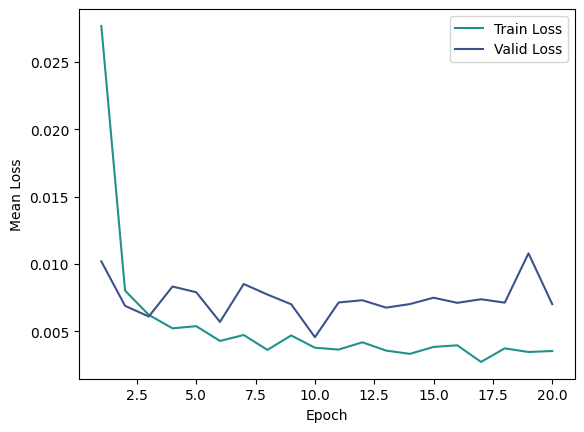

In [10]:
# Graph de la perte des moyennes
plt.figure()
plt.plot(range(1, num_epochs + 1),  train_losses, c='#21918c', label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, c='#3b528b', label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Loss')
# plt.title('Perte moyenne par Epoch')
plt.legend()
plt.show()

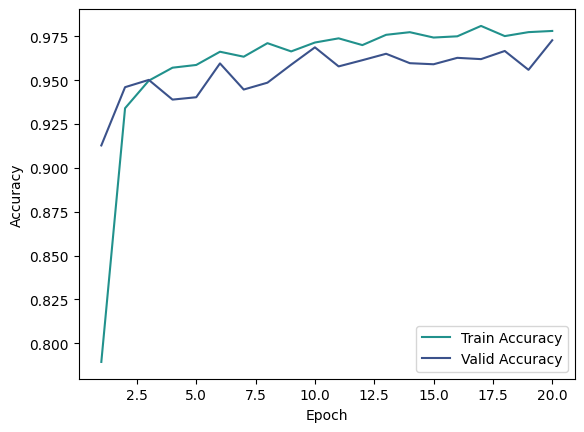

In [11]:
# Graph de l'exactitudes
plt.figure()
plt.plot(range(1, num_epochs + 1),  train_accuracies, c='#21918c', label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, c='#3b528b', label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.title('Accuracy par Epoch')
plt.legend()
plt.show()

In [15]:
# Sauvegarde du meilleur modèle
best_mycnn_checkpoint = torch.load(f'{MYCNN_CHECKPOINTS_DIR}/model_{best_epoch}.pt')
torch.save(best_mycnn_checkpoint, f'{MODELS_DIR}/mycnn_model.pt')

# Modèle avec meilleur paramètres
best_mycnn = MyCNN()
best_mycnn.load_state_dict(best_mycnn_checkpoint['model_state_dict'])
best_valid_accuracy = best_mycnn_checkpoint['valid_accuracy']
print(f'CNN : Meilleur exactitude de validation: {best_valid_accuracy:.2%}')

CNN : Meilleur exactitude de validation: 97.28%


In [ ]:
# Modèle en mode d'évalutaion
best_mycnn.eval()
best_mycnn.to(device)

test_correct = 0
all_preds = []
all_labels = []

# Prédictions du jeu de test
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        logit_outputs = best_mycnn(inputs)
        preds = logit_outputs.argmax(1)
        
        test_correct += (preds == labels).sum().item()
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculer l'accuracy, la précision, le rappel et le score F1
test_accuracy = test_correct / len(test_loader.dataset)
test_precision = precision_score(all_labels, all_preds, average='weighted')
test_recall = recall_score(all_labels, all_preds, average='weighted')
test_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Exactitude:  {test_accuracy:.2%}')
print(f'Precision: {test_precision:.2%}')
print(f'Rappel: {test_recall:.2%}')
print(f'Score F1: {test_f1:.2%}')

Exactitude:  98.32%
Precision: 98.34%
Rappel: 98.32%
Score F1: 98.32%


## Comparaison des augmentations

### Création d'un nouveau jeu de données

In [ ]:
# Répertoire des jeu de tests
MODIFS_TEST_DIR = 'modif_test'

# Drapeaux
selected_flags = ['bb','fi','gq','id','jm','ma','ng','ni','tn','uy']

# modificateurs
bright_transformer = v2.ColorJitter(brightness=1, contrast=1, saturation=0.4)
rotation_transformer = v2.RandomRotation(degrees=(-20,20))
blur_transformer = v2.GaussianBlur(kernel_size=15, sigma=(0.1, 5))
perspective_transformer = v2.RandomPerspective(distortion_scale=0.5, p=1)
wave_transformer = v2.ElasticTransform(alpha=125)

# dictionnaires des modifications
modif_dict = {'blur' : blur_transformer,
              'bright' : bright_transformer,
              'noise' : add_gaussian_noise,
              'perspective' : perspective_transformer,
              'rotation': rotation_transformer,
              'wave' : wave_transformer}

# Crée le dossier d'inputs
if not os.path.exists(MODIFS_TEST_DIR):
    os.makedirs(MODIFS_TEST_DIR)

    # Crée un dossier pour chaque modif
    for name, modif in modif_dict.items():
        print(name, modif)
        modif_dir = f'{MODIFS_TEST_DIR}/{name}' 

        os.makedirs(modif_dir, exist_ok=True)   

        # Crée des versions modifiés pour chaque drapeaux
        for flag in selected_flags:

            flag_dir = f'{modif_dir}/{flag}'
            os.makedirs(flag_dir, exist_ok=True)    

            img = Image.open(f'flags/{flag}.png').convert('RGB')
            img.thumbnail((512,512))

            for i in range(1,11):

                mod_img = modif(img)
                mod_img.save(f'{flag_dir}/{flag}_{i}.png')
else:
    print('Test Folder already exists.')

blur GaussianBlur(kernel_size=(15, 15), sigma=[0.1, 5.0])
bright ColorJitter(brightness=(0.0, 2.0), contrast=(0.0, 2.0), saturation=(0.6, 1.4))
noise <function add_gaussian_noise at 0x0000022E51A8C860>
perspective RandomPerspective(p=1, distortion_scale=0.5, interpolation=InterpolationMode.BILINEAR, fill=0)
rotation RandomRotation(degrees=[-20.0, 20.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
wave ElasticTransform(alpha=[125.0, 125.0], sigma=[5.0, 5.0], interpolation=InterpolationMode.BILINEAR, fill=0)


### Tests de chaque jeu

In [ ]:
# Chargement des modèles
# MODELS_DIR = 'models'
# knn_load = open(f'{MODELS_DIR}/knn_model', 'rb')
# svm_load = open(f'{MODELS_DIR}/svm_model', 'rb')
# best_knn = pickle.load(knn_load)
# best_svm = pickle.load(svm_load)
# best_checkpoint = torch.load(f'{MODELS_DIR}/resnet_model.pt')
# best_cnn = models.resnet18(weights='DEFAULT')
# best_cnn.fc = nn.Linear(512, 10)
# best_cnn.load_state_dict(best_checkpoint['model_state_dict'])

# Listes pour enregistrer les résultats
modifications = []
knn_accuracies = []
svm_accuracies = []
cnn_accuracies = []

for modif in os.listdir(MODIFS_TEST_DIR):
    
    # Ajouter la modification actuelle à la liste
    modifications.append(modif)
    
    # Traitement des données (kNN & SVM)
    images, labels = load_images(f'{MODIFS_TEST_DIR}/{modif}')
    test_images = preprocess_images(images, (32 ,32))
    labels = np.array(labels)

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    test_images = scaler.transform(test_images)
    
    # Test avec kNN
    knn_test_pred = best_knn.predict(test_images)
    knn_test_accuracy = accuracy_score(encoded_labels, knn_test_pred)
    knn_accuracies.append(knn_test_accuracy)
    print(f'{modif} | k-NN | accuracy: {knn_test_accuracy:.2%}')
    
    # Test avec SVM
    svm_test_pred = best_svm.predict(test_images)
    svm_test_accuracy = accuracy_score(encoded_labels, svm_test_pred)
    svm_accuracies.append(svm_test_accuracy)
    print(f'{modif} | SVM | accuracy: {svm_test_accuracy:.2%}')
    
    # Test avec CNN
    modif_test_dataset = datasets.ImageFolder(root=f'{MODIFS_TEST_DIR}/{modif}',
                                        transform = input_transform)

    modif_test_loader = DataLoader(modif_test_dataset, batch_size=32, shuffle=True)

    best_cnn.eval()
    best_cnn.to(device)

    modif_test_correct = 0
    for inputs, labels in modif_test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      logit_outputs = best_cnn(inputs)
      modif_test_correct += (logit_outputs.argmax(1) == labels).sum().item()

    cnn_test_accuracy = modif_test_correct / len(modif_test_loader.dataset)
    cnn_accuracies.append(cnn_test_accuracy)
    print(f'{modif} | CNN | accuracy: {cnn_test_accuracy:.2%}')


In [ ]:
# Barplot des Exactitudes selon modif & modèles

# Affichage des résultats dans un barplot
x = np.arange(len(modifications))  # position des labels sur l'axe x
width = 0.25  # largeur des barres

fig, ax = plt.subplots()
bar1 = ax.bar(x - width, knn_accuracies, width, color='#21918c', label='k-NN')
bar2 = ax.bar(x, svm_accuracies, width, color='#3b528b', label='SVM')
bar3 = ax.bar(x + width, cnn_accuracies, width, color='#440154', label='CNN')

# Ajouter des étiquettes, un titre et une légende
ax.set_xlabel('Modifications')
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(modifications)
ax.legend(loc='lower left')

# Fait pivoter les labels pour les rendre lisibles
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Prédiction d'une image

permet de tester les prédictions des modèles sur une images.

In [81]:
TEST_PATH = 'inputs/input_paint/ch_01.png'

# iso = ['bb','fi','gq','id','jm','ma','ng','ni','tn','uy']
with open(FLAG_LIST_DIR, 'r') as f:
    iso = [line[:-1] for line in f] 

In [87]:
# Prédiction du ResNet18
img = Image.open(TEST_PATH).convert('RGB')
img_tensor = input_transform(img).unsqueeze(0)

logodd = best_mycnn(img_tensor.to(device))
prob = torch.nn.functional.softmax(logodd, dim=1)[0]
_, indices = torch.sort(prob, descending=True)

for i in indices:
  print(iso[i], f': {prob[i].item():.2%}')

ch : 100.00%
at : 0.00%
ae : 0.00%
mm : 0.00%
mv : 0.00%
lv : 0.00%
sy : 0.00%
ye : 0.00%
dk : 0.00%
la : 0.00%
kw : 0.00%
ps : 0.00%
it : 0.00%
ie : 0.00%
pe : 0.00%
kg : 0.00%
ug : 0.00%
tn : 0.00%
vn : 0.00%
bi : 0.00%
bt : 0.00%
hu : 0.00%
no : 0.00%
ag : 0.00%
pl : 0.00%
sz : 0.00%
mx : 0.00%
be : 0.00%
es : 0.00%
al : 0.00%
ki : 0.00%
me : 0.00%
iq : 0.00%
cl : 0.00%
lb : 0.00%
bo : 0.00%
jo : 0.00%
nl : 0.00%
mk : 0.00%
et : 0.00%
fr : 0.00%
do : 0.00%
gq : 0.00%
ng : 0.00%
ci : 0.00%
ro : 0.00%
sd : 0.00%
ca : 0.00%
cd : 0.00%
cf : 0.00%
cg : 0.00%
cm : 0.00%
cn : 0.00%
co : 0.00%
cr : 0.00%
cu : 0.00%
cv : 0.00%
cy : 0.00%
cz : 0.00%
de : 0.00%
dj : 0.00%
dm : 0.00%
dz : 0.00%
ec : 0.00%
ee : 0.00%
eg : 0.00%
er : 0.00%
fi : 0.00%
fj : 0.00%
fm : 0.00%
ga : 0.00%
gb : 0.00%
gd : 0.00%
ge : 0.00%
gh : 0.00%
gm : 0.00%
gn : 0.00%
gr : 0.00%
gt : 0.00%
gw : 0.00%
gy : 0.00%
hn : 0.00%
hr : 0.00%
id : 0.00%
il : 0.00%
in : 0.00%
ir : 0.00%
is : 0.00%
jm : 0.00%
jp : 0.00%
ke : 0.0

In [85]:
# Prédiction avec kNN
test_img = cv2.imread(TEST_PATH)
test_img = preprocess_images([test_img], (32 ,32))
test_img = scaler.transform(test_img)

knn_prob = best_knn.predict_proba(test_img)

for i,prob in enumerate(knn_prob[0]):
  print(iso[i], f': {prob:.2%}')

ad : 0.00%
ae : 0.00%
af : 0.00%
ag : 0.00%
al : 0.00%
am : 0.00%
ao : 0.00%
ar : 0.00%
at : 0.00%
au : 0.00%
az : 0.00%
ba : 0.00%
bb : 0.00%
bd : 0.00%
be : 0.00%
bf : 0.00%
bg : 0.00%
bh : 0.00%
bi : 0.00%
bj : 0.00%
bn : 0.00%
bo : 0.00%
br : 0.00%
bs : 0.00%
bt : 0.00%
bw : 0.00%
by : 0.00%
bz : 0.00%
ca : 0.00%
cd : 0.00%
cf : 0.00%
cg : 0.00%
ch : 100.00%
ci : 0.00%
cl : 0.00%
cm : 0.00%
cn : 0.00%
co : 0.00%
cr : 0.00%
cu : 0.00%
cv : 0.00%
cy : 0.00%
cz : 0.00%
de : 0.00%
dj : 0.00%
dk : 0.00%
dm : 0.00%
do : 0.00%
dz : 0.00%
ec : 0.00%
ee : 0.00%
eg : 0.00%
er : 0.00%
es : 0.00%
et : 0.00%
fi : 0.00%
fj : 0.00%
fm : 0.00%
fr : 0.00%
ga : 0.00%
gb : 0.00%
gd : 0.00%
ge : 0.00%
gh : 0.00%
gm : 0.00%
gn : 0.00%
gq : 0.00%
gr : 0.00%
gt : 0.00%
gw : 0.00%
gy : 0.00%
hn : 0.00%
hr : 0.00%
ht : 0.00%
hu : 0.00%
id : 0.00%
ie : 0.00%
il : 0.00%
in : 0.00%
iq : 0.00%
ir : 0.00%
is : 0.00%
it : 0.00%
jm : 0.00%
jo : 0.00%
jp : 0.00%
ke : 0.00%
kg : 0.00%
kh : 0.00%
ki : 0.00%
km : 0.0

In [86]:
# Prédiciton avec SVM
svm_prob = best_svm.predict_proba(test_img)
for i,prob in enumerate(svm_prob[0]):
  print(iso[i], f': {prob:.2%}')

ad : 0.01%
ae : 0.02%
af : 0.00%
ag : 0.05%
al : 0.16%
am : 0.02%
ao : 0.01%
ar : 0.00%
at : 0.09%
au : 0.00%
az : 0.00%
ba : 0.00%
bb : 0.00%
bd : 0.00%
be : 0.03%
bf : 0.00%
bg : 0.00%
bh : 0.04%
bi : 0.04%
bj : 0.00%
bn : 0.01%
bo : 0.01%
br : 0.00%
bs : 0.00%
bt : 0.04%
bw : 0.00%
by : 0.01%
bz : 0.00%
ca : 0.02%
cd : 0.00%
cf : 0.00%
cg : 0.00%
ch : 95.65%
ci : 0.01%
cl : 0.01%
cm : 0.00%
cn : 0.09%
co : 0.01%
cr : 0.00%
cu : 0.00%
cv : 0.00%
cy : 0.00%
cz : 0.01%
de : 0.01%
dj : 0.00%
dk : 0.62%
dm : 0.00%
do : 0.01%
dz : 0.00%
ec : 0.07%
ee : 0.00%
eg : 0.01%
er : 0.00%
es : 0.08%
et : 0.01%
fi : 0.00%
fj : 0.00%
fm : 0.00%
fr : 0.00%
ga : 0.00%
gb : 0.01%
gd : 0.12%
ge : 0.00%
gh : 0.01%
gm : 0.00%
gn : 0.00%
gq : 0.01%
gr : 0.00%
gt : 0.00%
gw : 0.01%
gy : 0.00%
hn : 0.00%
hr : 0.01%
ht : 0.00%
hu : 0.01%
id : 0.03%
ie : 0.00%
il : 0.00%
in : 0.00%
iq : 0.01%
ir : 0.01%
is : 0.00%
it : 0.00%
jm : 0.00%
jo : 0.00%
jp : 0.00%
ke : 0.00%
kg : 0.28%
kh : 0.00%
ki : 0.01%
km : 0.00